In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set_context('talk')
%matplotlib inline

from helpers import *

Text(0,0.5,'ID')

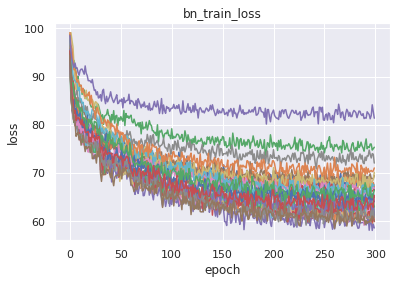

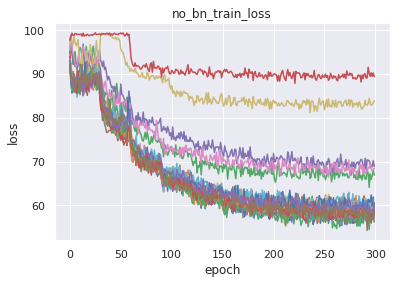

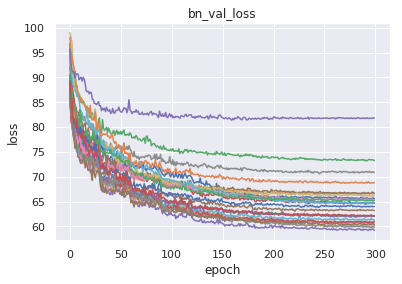

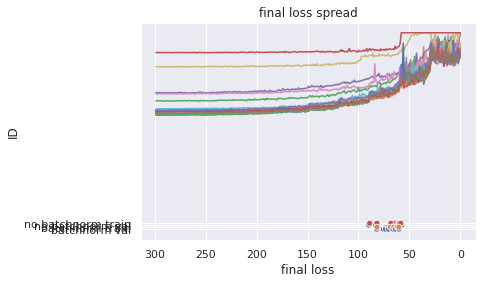

In [8]:
LOG_DIR = './CIFAR100/logs/'
logs = os.listdir(LOG_DIR)

bn_losses = []
no_bn_losses = []
for log in logs:
    if 'bn' in log:
        bn_losses.append(get_losses(LOG_DIR+log))
    else:
        no_bn_losses.append(get_losses(LOG_DIR+log))
bn_losses = np.array(bn_losses)
no_bn_losses = np.array(no_bn_losses)

bn_train_loss = pd.DataFrame(data=bn_losses[:,0,:].T)
bn_val_loss = pd.DataFrame(data=bn_losses[:,1,:].T)
no_bn_train_loss = pd.DataFrame(data=no_bn_losses[:,0,:].T)
no_bn_val_loss = pd.DataFrame(data=no_bn_losses[:,1,:].T)

names = ['bn_train_loss','no_bn_train_loss','bn_val_loss','no_bn_val_loss']
for i, log in enumerate([bn_train_loss,no_bn_train_loss,bn_val_loss,no_bn_val_loss]):
    ax = log.plot(legend=False)
    ax.set_title(names[i])
    ax.set_ylabel('loss')
    ax.set_xlabel('epoch')

logs_final = []
for log in logs:
    losses = get_losses(LOG_DIR+log)
    losses = np.array([np.insert(losses[1],0,99),np.insert(losses[0],0,99)])
    logs_final.append([log+'-final-imageset_val', np.mean(losses[1][290:-1]), losses[1]])
    logs_final.append([log+'-final-imageset_train', np.mean(losses[0][290:-1]), losses[0]])
    
    
log_df = pd.DataFrame(columns=["log", "final loss", "full loss"], data=logs_final)
log_df['snipped log'] = log_df['log'].apply(lambda x : str(x.split('_')[-2]).split('-')[0]+' '+str(x.split('_')[-1]))
log_df['snipped log'] = log_df['snipped log'].apply(lambda x : x.replace('sc', 'no batchnorm'))
log_df['snipped log'] = log_df['snipped log'].apply(lambda x : x.replace('bn', 'batchnorm'))

ax = sns.scatterplot(x='final loss',y='snipped log', hue='snipped log', legend=False, data=log_df)
ax.invert_xaxis()
ax.set_title('final loss spread')
ax.set_ylabel('ID')

In [142]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

def match_strings(strings, path):
    return all([string in path for string in strings])

def load_data(mani_dir, exclude=[]):
    paths = np.sort(np.array(os.listdir(mani_dir)))
    paths = [path for path in paths if not match_strings(exclude, path)] 
    data = np.array([loadmat(mani_dir+path) for path in paths])
    return paths, data

def get_layer_type(path, types):
    for t in types:
        if t in path:
            return t

def frame_constructor(paths, data, key, tag=None, mean=False, verbose=False):
    perm_seed = [catch(path, 'seed') for path in paths]
    ft_size = [path.split('_')[1] for path in paths]
    lnum = [path.split('-')[2].split('_')[1] for path in paths]
    coding = [path.split('-')[2].split('_')[0] for path in paths]
    epochs = np.array([path.split('-')[1].split('_')[1] for path in paths])
    image_set = np.array([path.split('-')[0] for path in paths])
    
    data_vec = np.array([np.squeeze(datum[key]) for datum in data])
    if mean:
        data_vec = np.mean(data_vec,axis=1)
    data_vec = np.atleast_2d(data_vec)    
    if verbose:
        print('data_vec.shape: ', data_vec.shape)
    if data_vec.shape[0]<data_vec.shape[1]:
        data_vec = data_vec.T
        
    df = pd.DataFrame(
        columns=[
            'path', 
            'image set',
            'epoch',
            'layer number',
            'coding',
            'perm seed', 
            'feature size', 
            'value', 
            'measure',
            'tag'
        ], 
        data=np.array([
            np.repeat([paths],data_vec.shape[-1],axis=0).T.reshape(-1),
            np.repeat([image_set],data_vec.shape[-1],axis=0).T.reshape(-1),
            np.repeat([epochs],data_vec.shape[-1],axis=0).T.reshape(-1),
            np.repeat([lnum],data_vec.shape[-1],axis=0).T.reshape(-1),
            np.repeat([coding],data_vec.shape[-1],axis=0).T.reshape(-1),
            np.repeat([perm_seed],data_vec.shape[-1],axis=0).T.reshape(-1),
            np.repeat([ft_size],data_vec.shape[-1],axis=0).T.reshape(-1),
            data_vec.reshape(-1),
            np.repeat(key,data_vec.size),
            np.repeat(tag,data_vec.size)
        ]).T
    )
    
    types = ['MaxPool2d', 'Conv2d', 'ReLU', 'Linear', 'BatchNorm2d']
    df['type'] = df.path.apply(lambda x: get_layer_type(x, types))
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df['epoch'] = pd.to_numeric(df['epoch'], errors='coerce')
    df['perm seed'] = pd.to_numeric(df['perm seed'], errors='coerce')
    df['feature size'] = pd.to_numeric(df['feature size'], errors='coerce')
    df['layer number'] = pd.to_numeric(df['layer number'], errors='coerce')
    df.loc[df['coding']=='classifier', 'layer number'] = df.loc[
        df['coding']=='classifier', 'layer number'] + df[
        (df['coding']=='features') & (df['image set']=='train') & (df['epoch']==1) # this breaks if epoch 1 is not in the mix..
    ].shape[0]-1    
    
    return df

def compile_info(mani_dir, path):
    mani_dir.replace('manifold_', '-')
    info = path.replace('.h5', '')
    info += '-seed_'+catch(mani_dir, 'seed', ind=2)
    
    return info

def multi_frame_constructor(mani_dirs, tags, measures, exclude=[], verbose=False):
    df = None
    for i, mani_dir in enumerate(mani_dirs):
        paths, data = load_data(mani_dir, exclude=exclude)
        paths_info = [compile_info(mani_dir, path) for path in paths]
#         print(paths_info)
        for measure in measures:
            mean = True
            if measure in ['CCcorr', 'pr', 'K0', 'S_vec']: mean = False
            if type(df) == type(None):
                df = frame_constructor(paths_info, data, measure, tag=tags[i], mean=mean, verbose=verbose)
            else:
                df = df.append(frame_constructor(paths_info, data, measure, tag=tags[i], mean=mean))
    return df
  
def make_contiguous(a):
    return np.arange(len(a))
    
def display(df, measure, coding, title, opts={'sortby':[], 'hue':'tag', 'fix_legend':False, 'dims': (12,7)}):
    unique_tags = np.unique(df.tag.values)
    data = df[
        (df['measure']==measure)
#         &(df['coding']==coding)
    ].sort_values(by=['layer number']).copy()
    
    for unique_tag in unique_tags:
        contiguous_layer_num = make_contiguous(data[data['tag']==unique_tag]['layer number'].values)
        data.loc[data['tag']==unique_tag, 'layer number'] = contiguous_layer_num
    
    # re sort by layer number, as everything will be shifted if one set was not contiguous
    data = data.sort_values(by=['layer number'])
    xlabels = data['type'].values[::len(unique_tags)]
    
    if len(opts['sortby'])>0:
        data = data.sort_values(by=opts['sortby'])
    
    fig, ax = plt.subplots(figsize=opts['dims'])
    p = sns.cubehelix_palette(len(unique_tags), start=2, rot=0, dark=0, light=.80)
    ax = sns.scatterplot(x="type", 
                         y="value", 
#                          units="tag",
                         size='tag',
                         sizes=(150,150),
                         ax=ax,
                         hue=opts['hue'],
                         palette=p,
                         data=data)

    if opts['fix_legend']:
        handles, labels = ax.get_legend_handles_labels()
        l = plt.legend(handles[0:1+len(unique_tags)], labels[0:1+len(unique_tags)], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    else:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    ax.set_title(title)
    ax.set_ylabel('mean {}'.format(measure.replace('_vec','')))
    ax.set_xticks(ticks=range(len(data.type)/len(unique_tags)))
    ax.set_xticklabels(xlabels,rotation=90)
    ax.set_xlabel('layer type')
    return data

def get_losses(log, epochs=300):
    f = open(log)
    val_loss = 100-np.array([float(line.split(' ')[3]) for line in f if " * Prec@1" in line])
    f = open(log)
    train_loss = np.array([float(line.split(" ")[8]) for line in f if ("Prec@1" in line) & ("Epoch" in line)])
    step_num = len(train_loss)/epochs
    train_loss = 100-np.array([train_loss[i*step_num:i*step_num+step_num].mean() for i in range(epochs)])
    
    return train_loss, val_loss

def plot_losses(log):
    train_loss, val_loss = get_losses(log)
    ax = pd.DataFrame(columns=['training error', 'validation error'], data=np.array([train_loss, val_loss]).T).plot()
    ax.set_xlabel('Epoch number')
    ax.set_ylabel('Error (%)')
    ax.set_title('Training curves')
    
def catch(filepath, target, ind=1):
    parts = filepath.split('-')
    match = [part for part in parts if target in part]
    if len(match) == 1:
        return match[0].split('_')[ind]
    else:
        print('target {} not found in filepath {}'.format(target,filepath))
        return None

def get_meta_dict(filepath,targets):
    """get_meta_dict(fs, ['seed', 'drop', 'imageset'])"""
    meta_dict = {}
    for target in targets:
        meta_dict[target] = catch(filepath,target)
        
    return meta_dict

def add_meta(df,targets):
    for target in targets:
        df[target] = df['log'].apply(lambda x : catch(x,target))

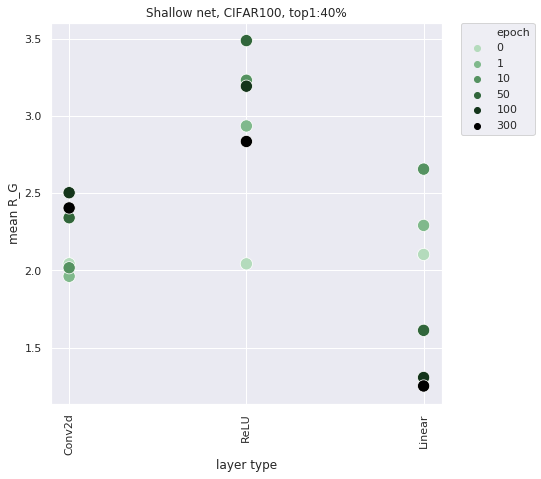

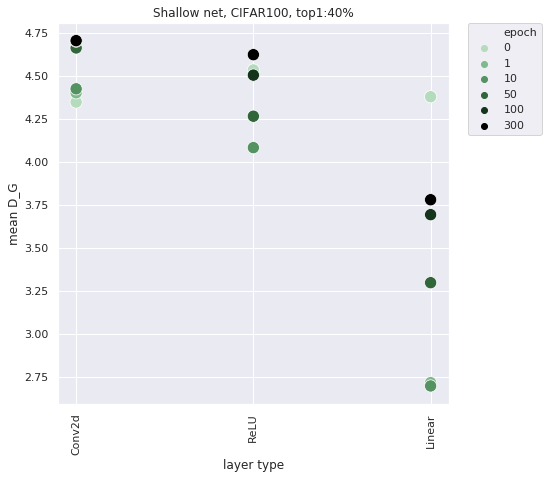

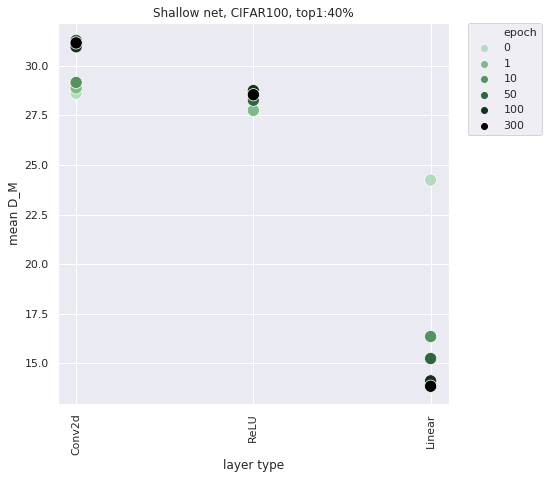

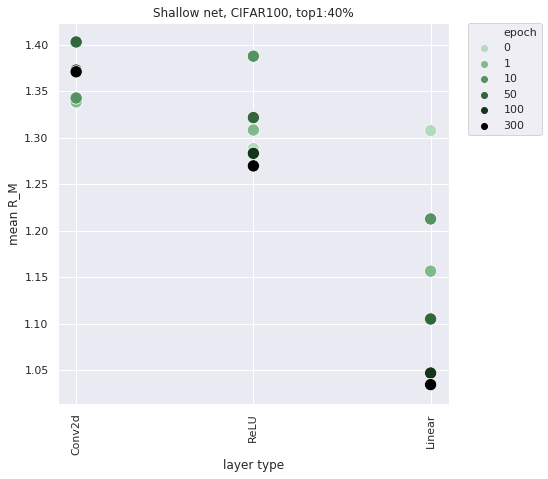

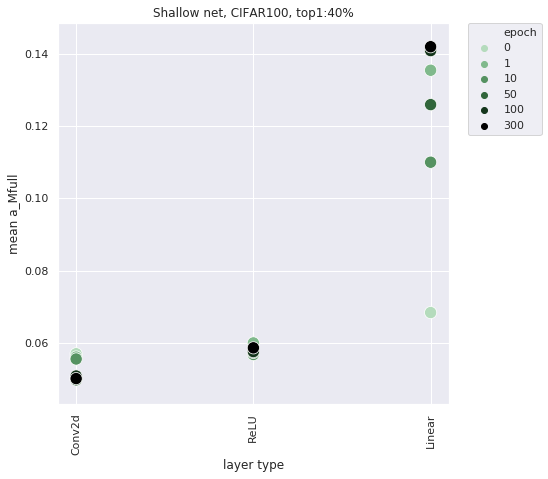

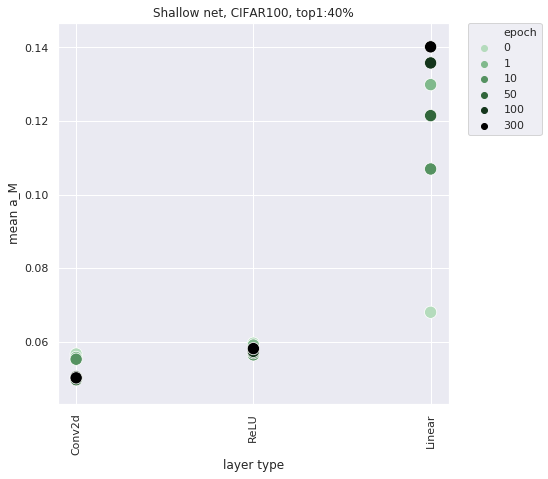

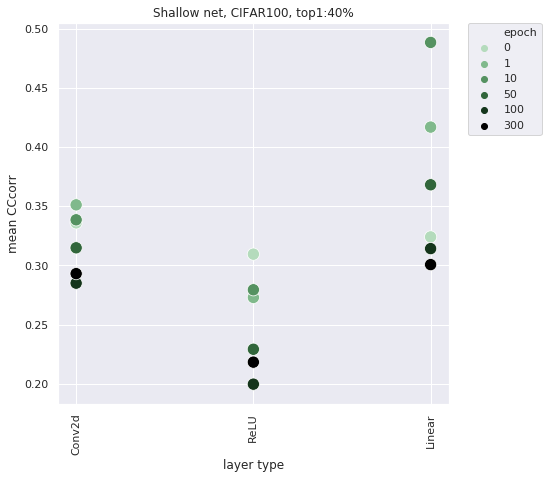

In [143]:
measures = ['R_G_vec', 'D_G_vec', 'D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']
mani_dirs = [
    '../dump/manifold_seed_14-drop_0-vgg1_sc-formatted_features-sort_betasoftmax/'
]

tags = [ 
    "seed_14 ep:" 
]

df = multi_frame_constructor(mani_dirs, tags, measures, exclude=['input'])

df['tag'] = df['tag']+df['epoch'].astype(str)

opts = {
    'dims':[7,7],
    'sortby': ['epoch'],
    'hue': 'epoch',
    'fix_legend':True
}

# df_filtered = df[(df['image set']=='train')&(df['epoch']==300)]
df_filtered = df[(df['image set']=='train')]

# r*d**(1/2)

for measure in measures:
    data = display(df_filtered, measure, 'features', 'Shallow net, CIFAR100, top1:40%', opts=opts)

In [144]:
measures = ['R_G_vec', 'D_G_vec', 'D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']

path_template = '../dump/manifold_seed_{}-drop_0-vgg1_sc-formatted_features-sort_betasoftmax/'
tag_template = '{}'
seed_range = range(0,11)
mani_dirs = [path_template.format(i) for i in seed_range]
tags = [tag_template.format(i) for i in seed_range]

df = multi_frame_constructor(mani_dirs, tags, measures, exclude=['input'])

# matching logs currently requires the tag to be the seed.
add_meta(log_df, ['seed', 'drop', 'imageset'])
log_df['bn'] = log_df['snipped log'].apply(lambda x: 'bn' in x)
df['loss'] = df.T.apply(lambda x : log_df[(log_df['seed'] == x.tag)&(log_df['imageset'] == x['image set'])&(log_df['bn'] == False)]['full loss'].values[0][x.epoch])
df['loss'] = pd.to_numeric(df['loss'], errors='coerce')

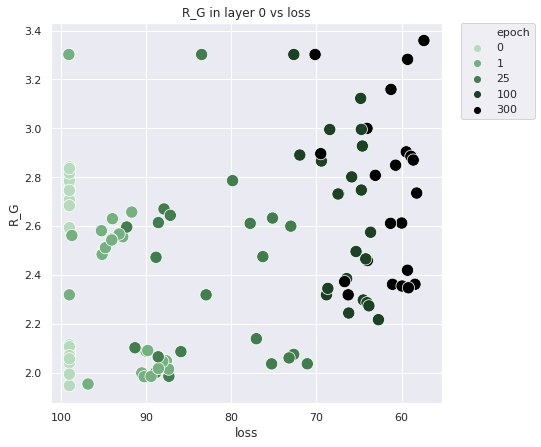

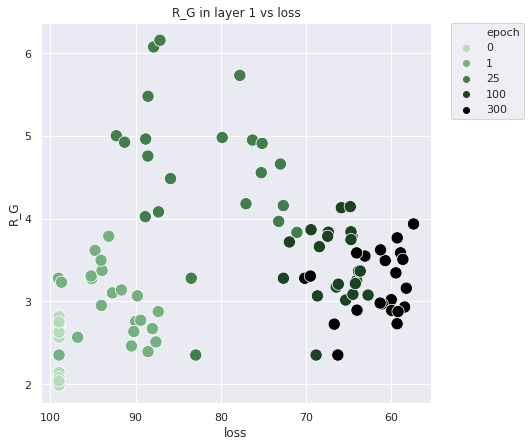

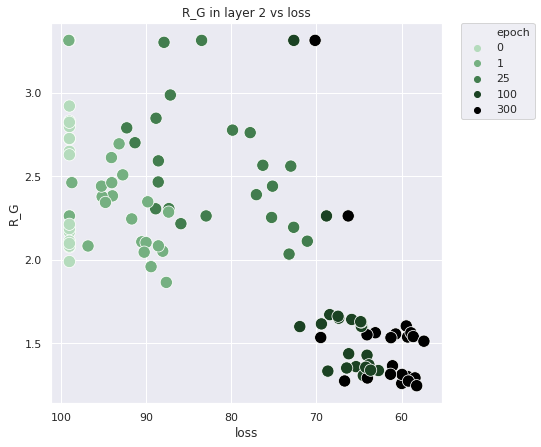

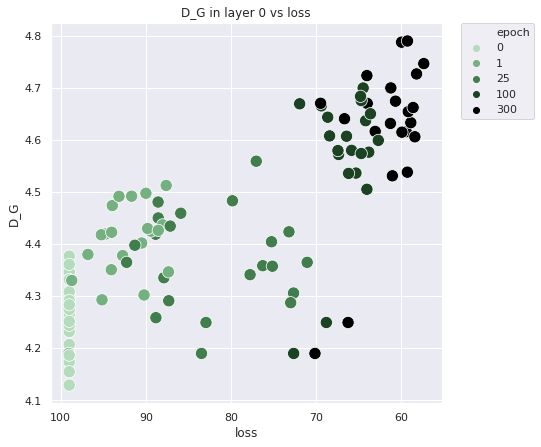

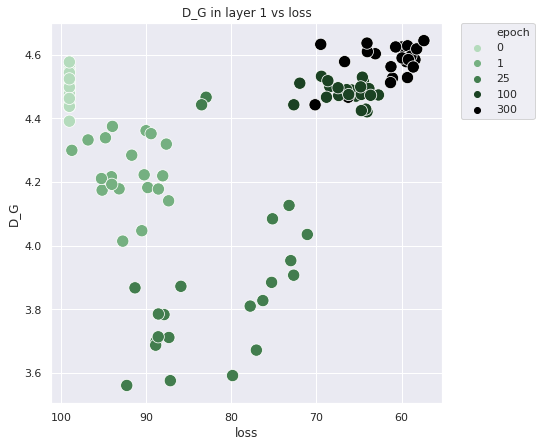

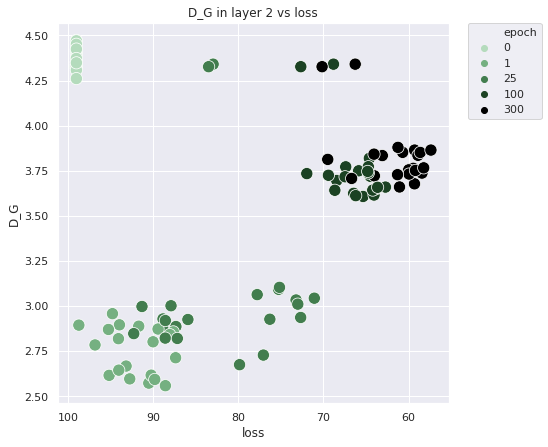

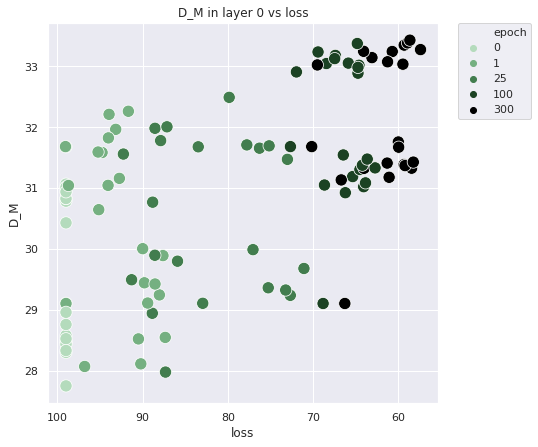

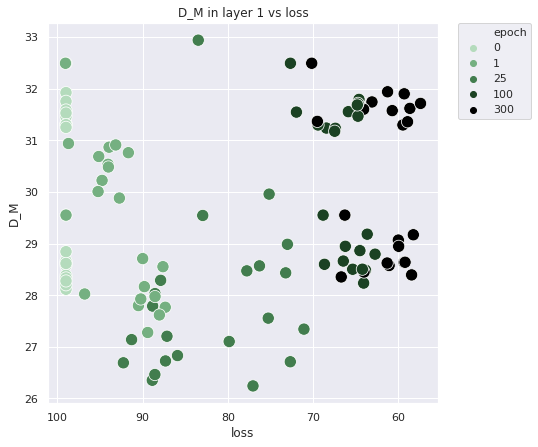

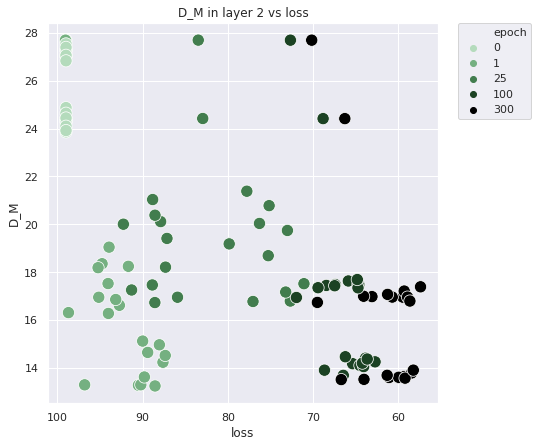

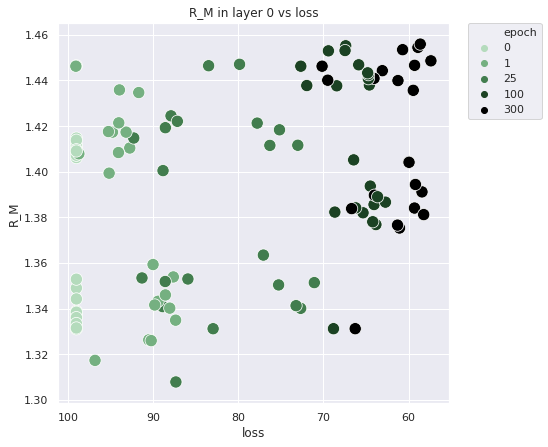

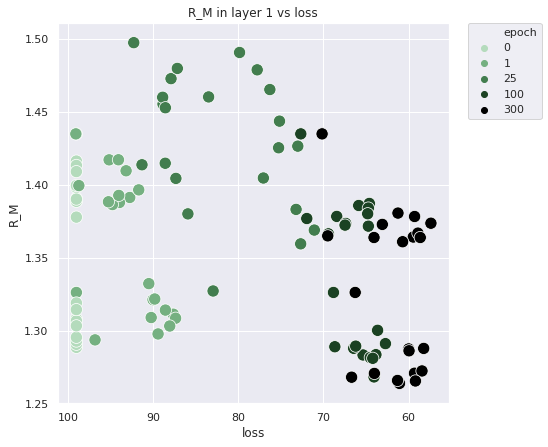

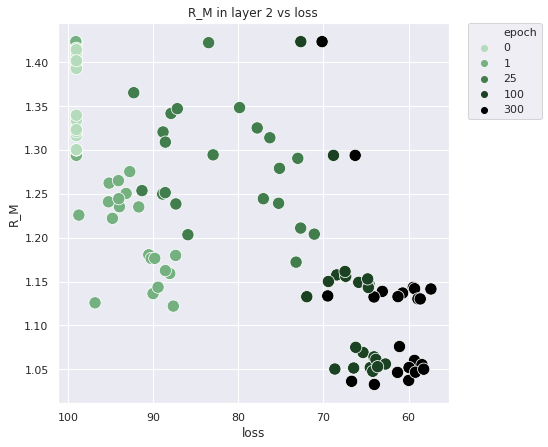

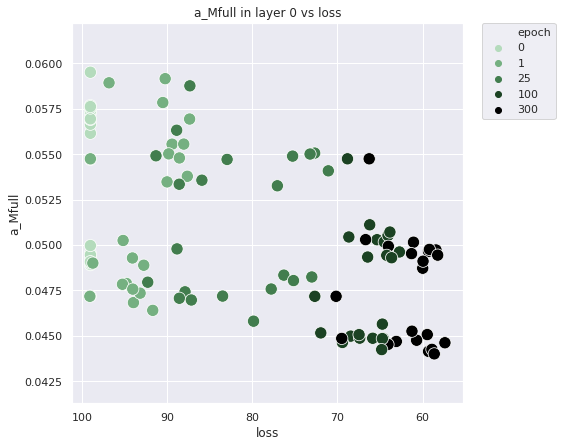

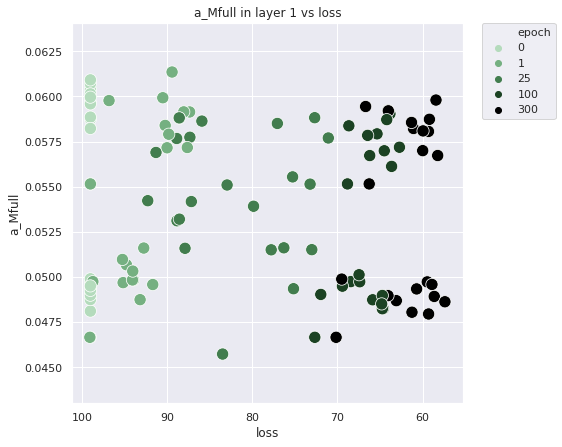

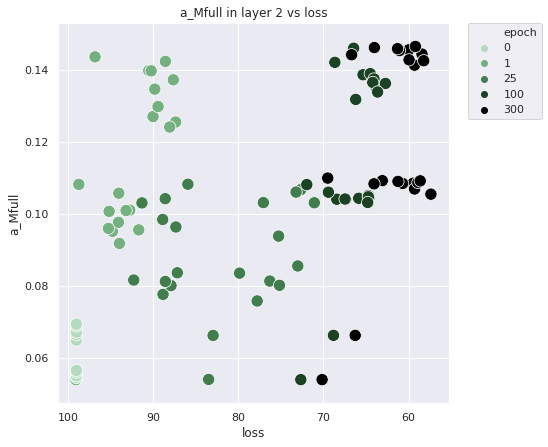

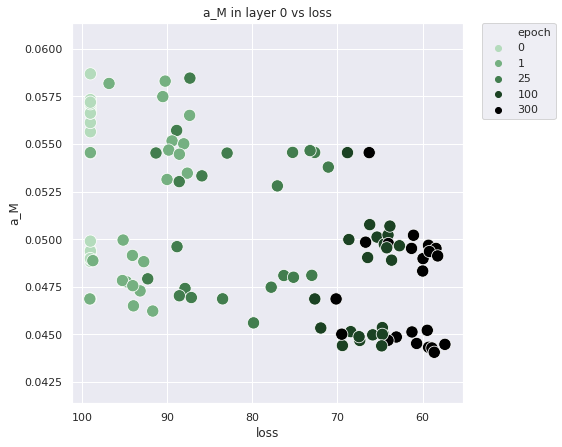

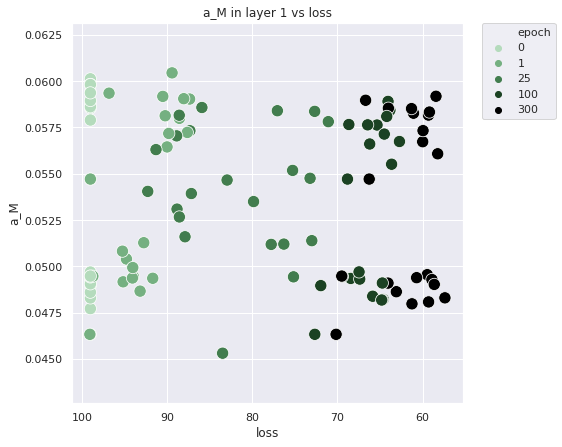

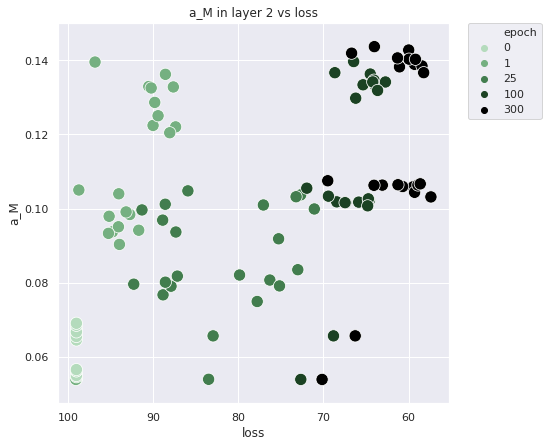

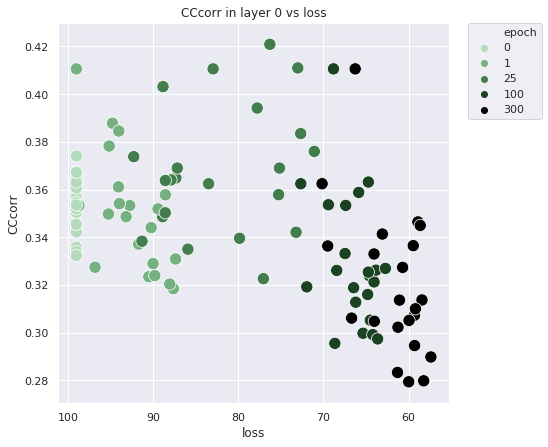

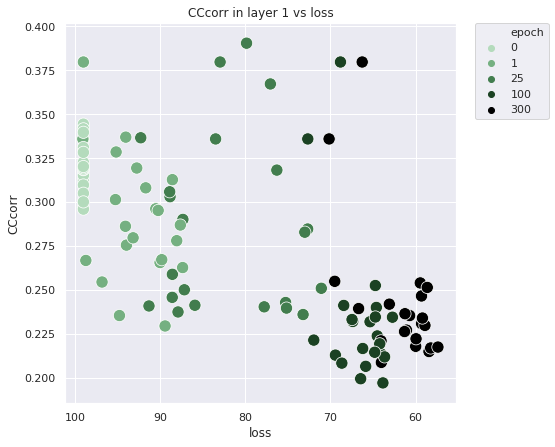

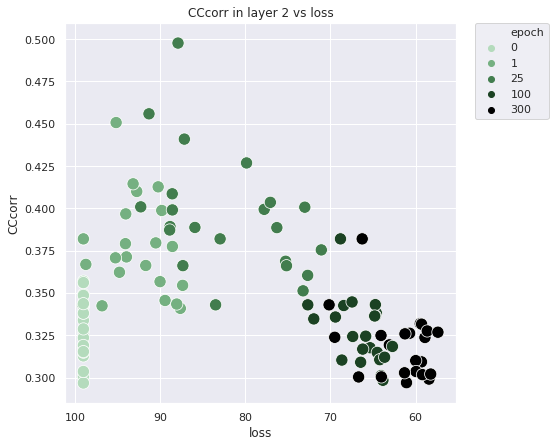

In [145]:
for m in measures:
    for l_num in range(0,3):
        fig, ax = plt.subplots(figsize=opts['dims'])
        p = sns.cubehelix_palette(5, start=2, rot=0, dark=0, light=.80)
        ax = sns.scatterplot(x='loss', 
                             y="value", 
        #                          units="tag",
                             size=1,
                             sizes=(150,150),
                             ax=ax,
                             hue='epoch',
                             palette=p,
                             data=df[(df.measure==m)&(df['layer number']==l_num)])

        handles, labels = ax.get_legend_handles_labels()
        l = plt.legend(handles[0:6], labels[0:6], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        measure_name = m.replace('_vec','')
        ax.invert_xaxis()
        ax.set_title('{} in layer {} vs loss'.format(measure_name, l_num))
        ax.set_ylabel(measure_name)

ValueError: estimator must be None when specifying units

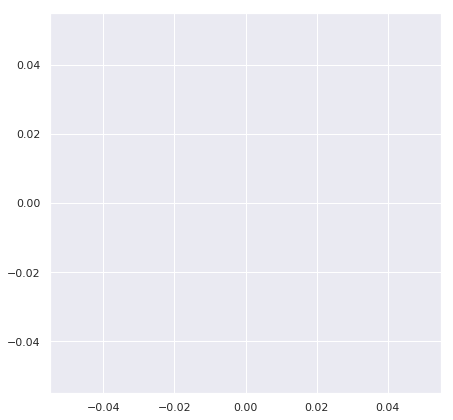

In [84]:
for m in measures:
    for l_num in range(0,3):
        fig, ax = plt.subplots(figsize=opts['dims'])
        p = sns.cubehelix_palette(11, start=2, rot=0, dark=0, light=.80)
        ax = sns.lineplot(
            x='loss', 
            y="value", 
        #                          units="tag",
#              size=1,
#              sizes=(150,150),
             ax=ax,
             hue='tag',
             palette=p,
             data=df[(df.measure==m)&(df['layer number']==l_num)])

        handles, labels = ax.get_legend_handles_labels()
        l = plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        measure_name = m.replace('_vec','')
        ax.invert_xaxis()
        ax.set_title('{} in layer {} vs loss'.format(measure_name, l_num))
        ax.set_ylabel(measure_name)

## todo
plot correlation of measures with loss
fix frames to be better
compute 
 - gaussian capacity
 - gaussian mean width
add inputs to plots

fix PR, add VE dimensionality,

## Old results, based on random sampling of manifold points

(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 34)
(1, 34)
(1, 34)
(1, 34)
(1, 34)


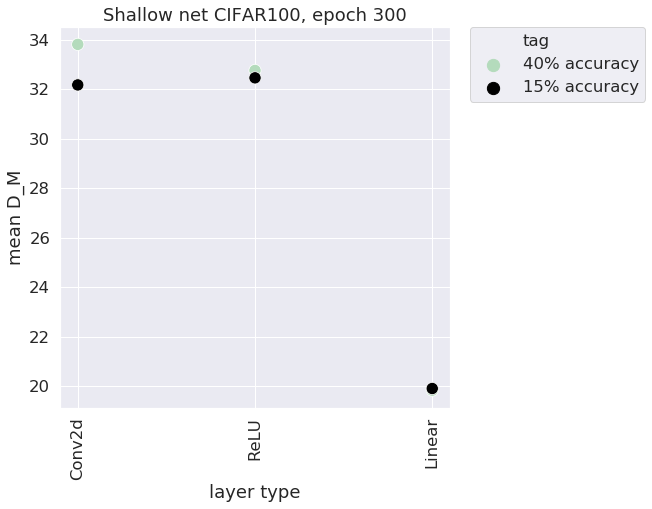

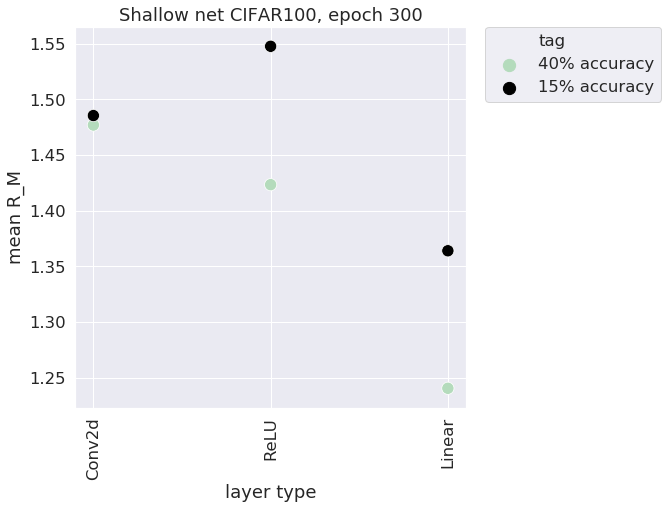

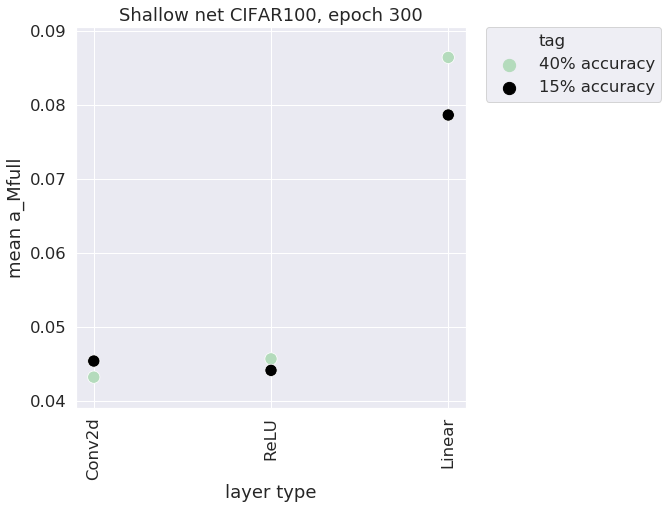

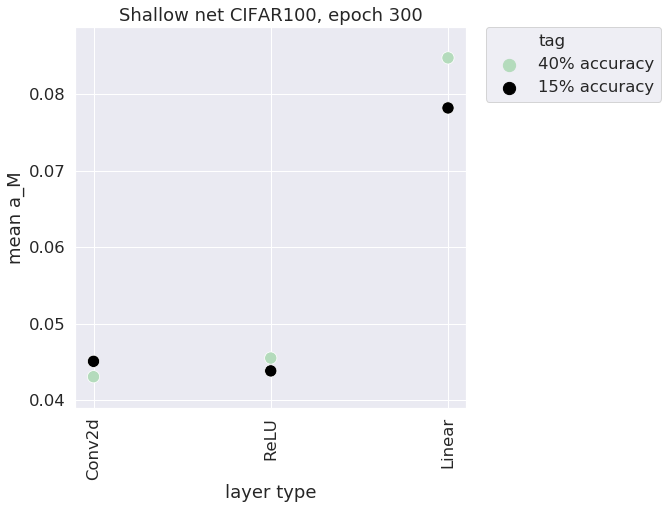

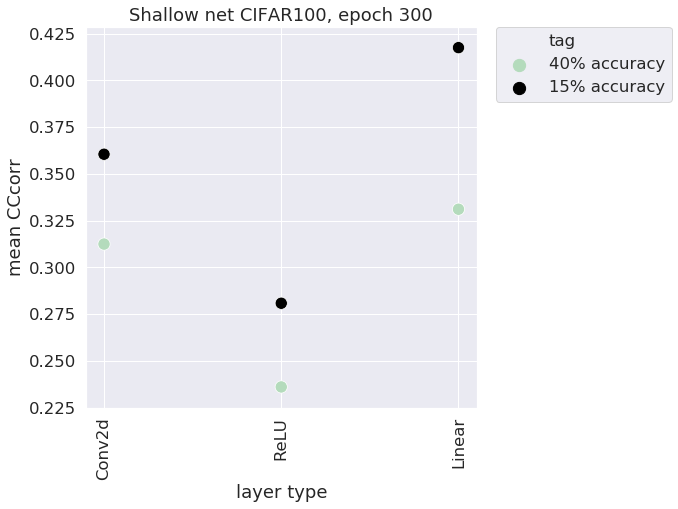

In [271]:
measures = ['D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']
mani_dirs = [
    '../dump/manifold_seed_0-drop_0-vgg1_sc-formatted_features-sort_random/',
    '../dump/manifold_seed_16-drop_0-vgg1_sc-formatted_features-sort_random/'
]

tags = [
    "40% accuracy",
    "15% accuracy" 
]

df = multi_frame_constructor(mani_dirs, tags, measures)

ep=300
df_filtered = df[(df['image set']=='train')&(df['epoch']==ep)]
df_filtered = df_filtered[(df_filtered['image set']=='train')&(df_filtered['type']!='BatchNorm2d')]


opts = {
    'dims':[7,7],
    'sortby': [],
    'hue': 'tag',
    'fix_legend':False
}

for measure in measures:
    data = display(df_filtered, measure, 'features', 'Shallow net CIFAR100, epoch {}'.format(ep), opts=opts)

(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 48)
(1, 48)
(1, 48)
(1, 48)
(1, 48)


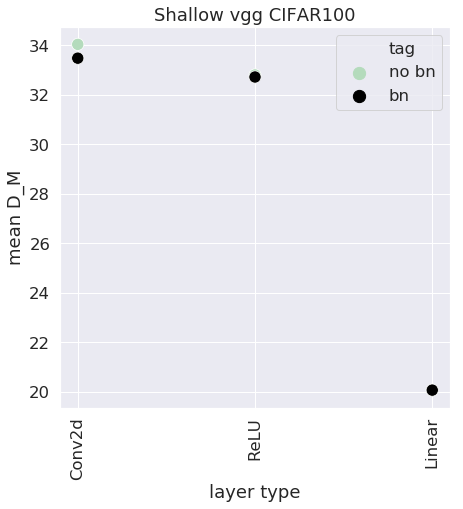

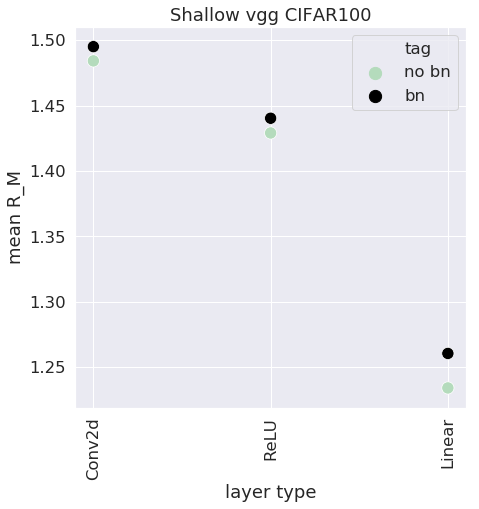

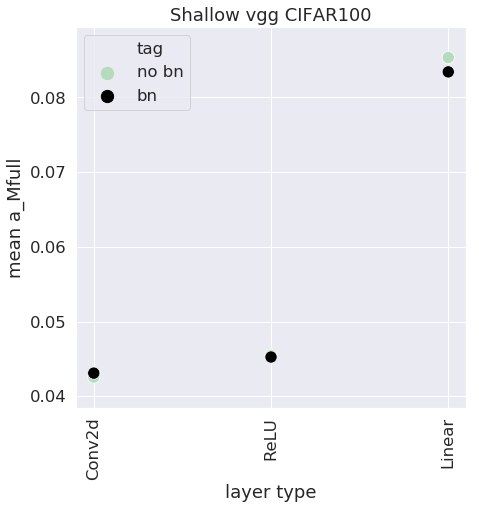

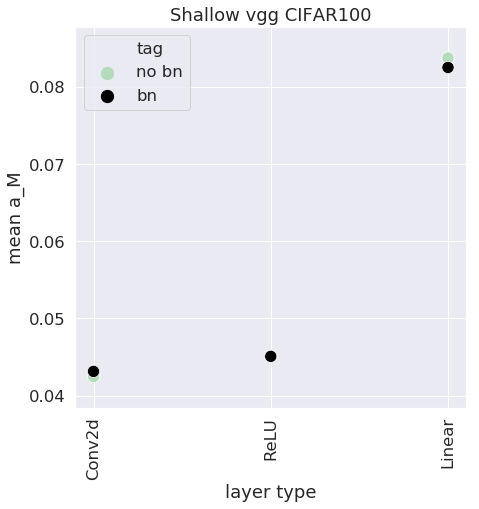

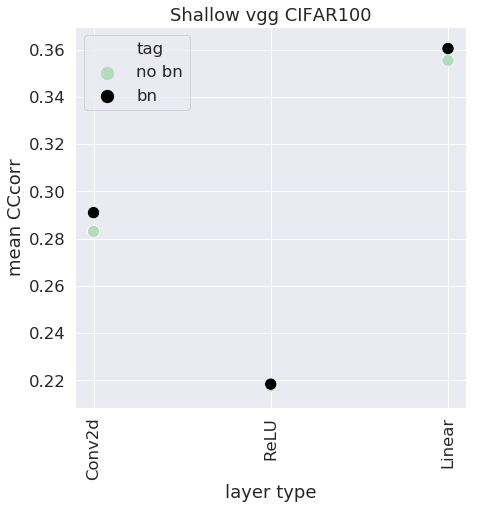

In [135]:
measures = ['D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']
mani_dirs = [
    '../dump/manifold_seed_1-drop_0-vgg1_sc-formatted_features-sort_random/',
    '../dump/manifold_seed_2-drop_0-vgg1_sc_bn-formatted_features-sort_random/'
]

tags = [
    "no bn",
    "bn" 
]

df = multi_frame_constructor(mani_dirs, tags, measures)

# df['tag'] = df['tag']+df['epoch'].astype(str)


df_filtered = df[(df['image set']=='train')&(df['epoch']==300)]
df_filtered = df_filtered[(df_filtered['image set']=='train')&(df_filtered['type']!='BatchNorm2d')]

# df_filtered = df[(df['image set']=='train')]
opts = {
    'dims':[7,7],
    'sortby': [],
    'hue': 'tag',
    'fix_legend':False
}

for measure in measures:
    data = display(df_filtered, measure, 'features', 'Shallow vgg CIFAR100', opts=opts)

In [279]:
measures = ['D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']
mani_dirs = [
    '../dump/manifold_seed_0-drop_0-vgg1_sc-formatted_features-sort_random/',
    '../dump/manifold_seed_1-drop_0-vgg1_sc-formatted_features-sort_random/',
    '../dump/manifold_seed_2-drop_0-vgg1_sc-formatted_features-sort_random/',
    '../dump/manifold_seed_4-drop_0-vgg1_sc-formatted_features-sort_random/',
    '../dump/manifold_seed_13-drop_0-vgg1_sc-formatted_features-sort_random/',
    '../dump/manifold_seed_15-drop_0-vgg1_sc-formatted_features-sort_random/',
    '../dump/manifold_seed_16-drop_0-vgg1_sc-formatted_features-sort_random/',
    '../dump/manifold_seed_20-drop_0-vgg1_sc-formatted_features-sort_random/'
]

tags = [
    "0",
    "1", 
    "2", 
    "3", 
    "4", 
    "13", 
    "15", 
    "16",
    "20"
]

df = multi_frame_constructor(mani_dirs, tags, measures)

(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 26)
(1, 26)
(1, 26)
(1, 26)
(1, 26)
(1, 34)
(1, 34)
(1, 34)
(1, 34)
(1, 34)
(1, 32)
(1, 32)
(1, 32)
(1, 32)
(1, 32)


In [35]:
df.shape, log_df.shape

((2310, 11), (104, 8))

In [33]:
add_meta(log_df, ['seed', 'drop', 'imageset'])
log_df['bn'] = log_df['snipped log'].apply(lambda x: 'bn' in x)
log_df.tail()

,log,final loss,full loss,snipped log,seed,drop,imageset,bn
99,seed_8-drop_0-vgg1_sc-log-final-imageset_train,58.48200,"[99.0, 91.23, 86.05, 88.36, 87.07, 84.78, 85.4...",no batchnorm train,8,0,train,False
100,seed_6-drop_0-vgg1_sc_bn-log-final-imageset_val,82.13677,"[99.0, 98.4766, 95.1952, 93.5547, 92.6172, 91....",batchnorm val,6,0,val,False
101,seed_6-drop_0-vgg1_sc_bn-log-final-imageset_train,81.78100,"[99.0, 95.84, 92.58, 91.37, 91.24, 90.9, 89.84...",batchnorm train,6,0,train,False
102,seed_15-drop_0-vgg1_sc_bn-log-final-imageset_val,60.21874,"[99.0, 94.3749, 86.7187, 84.2969, 83.4765, 80....",batchnorm val,15,0,val,False
103,seed_15-drop_0-vgg1_sc_bn-log-final-imageset_t...,60.43700,"[99.0, 86.78999999999999, 83.03999999999999, 8...",batchnorm train,15,0,train,False


In [34]:
df['loss'] = df.T.apply(lambda x : log_df[(log_df['seed'] == x.tag)&(log_df['imageset'] == x['image set'])&(log_df['bn'] == False)]['full loss'].values[0][x.epoch])
df['loss'] = pd.to_numeric(df['loss'], errors='coerce')
df.tail()

IndexError: ('index 0 is out of bounds for axis 0 with size 0', u'occurred at index 0')

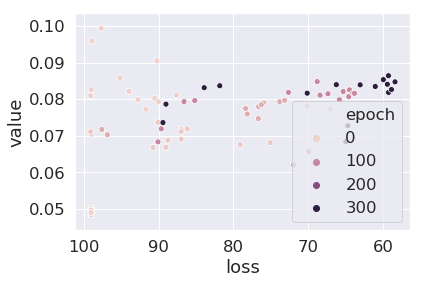

In [282]:
df[(df.measure=='a_Mfull_vec')&(df['layer number']==3)]

ax = sns.scatterplot(x='loss',
                y='value',
                hue='epoch',
                data=df[(df.measure=='a_Mfull_vec')&(df['layer number']==3)])

ax.invert_xaxis()

Text(0.5,1,'')

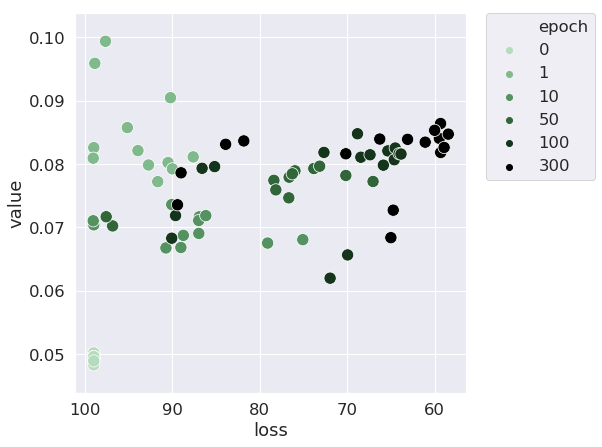

In [285]:
fig, ax = plt.subplots(figsize=opts['dims'])
p = sns.cubehelix_palette(6, start=2, rot=0, dark=0, light=.80)
ax = sns.scatterplot(x='loss', 
                     y="value", 
#                          units="tag",
                     size=1,
                     sizes=(150,150),
                     ax=ax,
                     hue='epoch',
                     palette=p,
                     data=df[(df.measure=='a_Mfull_vec')&(df['layer number']==3)])

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:7], labels[0:7], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
ax.invert_xaxis()
ax.set_title('')

Text(0.5,1,'')

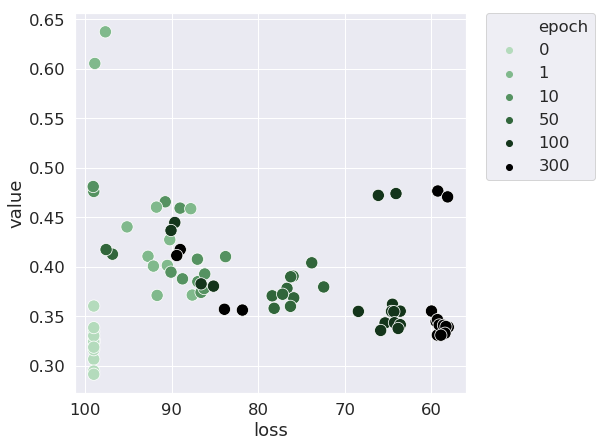

In [257]:
fig, ax = plt.subplots(figsize=opts['dims'])
p = sns.cubehelix_palette(6, start=2, rot=0, dark=0, light=.80)
ax = sns.scatterplot(x='loss', 
                     y="value", 
#                          units="tag",
                     size=1,
                     sizes=(150,150),
                     ax=ax,
                     hue='epoch',
                     palette=p,
                     data=df[(df.measure=='CCcorr')&(df['layer number']==3)])

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:7], labels[0:7], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
ax.invert_xaxis()
ax.set_title('')

Text(0.5,1,'')

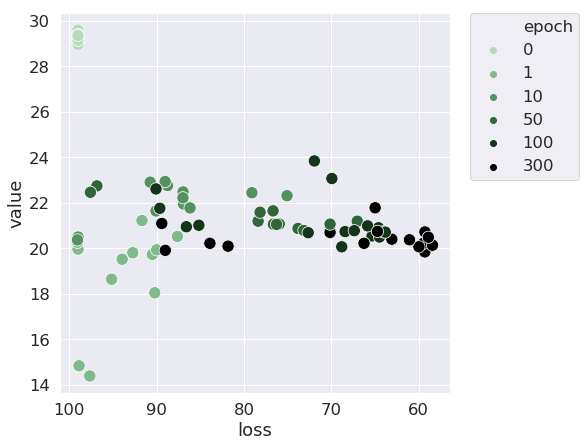

In [286]:
fig, ax = plt.subplots(figsize=opts['dims'])
p = sns.cubehelix_palette(6, start=2, rot=0, dark=0, light=.80)
ax = sns.scatterplot(x='loss', 
                     y="value", 
#                          units="tag",
                     size=1,
                     sizes=(150,150),
                     ax=ax,
                     hue='epoch',
                     palette=p,
                     data=df[(df.measure=='D_M_vec')&(df['layer number']==3)])

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:7], labels[0:7], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
ax.invert_xaxis()
ax.set_title('')

Text(0.5,1,'')

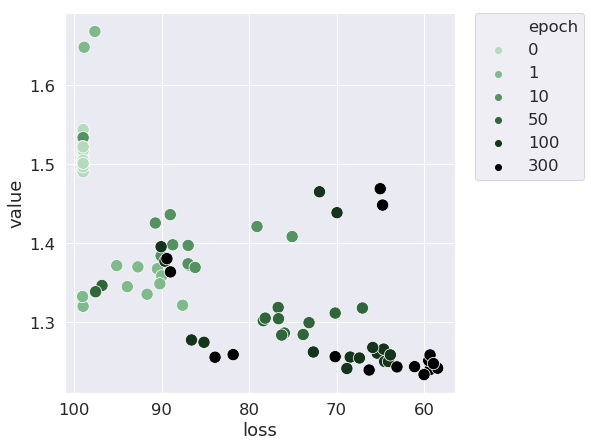

In [287]:
fig, ax = plt.subplots(figsize=opts['dims'])
p = sns.cubehelix_palette(6, start=2, rot=0, dark=0, light=.80)
ax = sns.scatterplot(x='loss', 
                     y="value", 
#                          units="tag",
                     size=1,
                     sizes=(150,150),
                     ax=ax,
                     hue='epoch',
                     palette=p,
                     data=df[(df.measure=='R_M_vec')&(df['layer number']==3)])

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:7], labels[0:7], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
ax.invert_xaxis()
ax.set_title('')

In [345]:
measures = ['S_vec', 'pr', 'R_G_vec', 'D_G_vec', 'D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']
mani_dirs = [
    '../dump/manifold_seed_14-drop_0-vgg1_sc-formatted_features-sort_betasoftmax/'
]

tags = [
    "seed_14 ep:" 
]

df = multi_frame_constructor(mani_dirs, tags, measures)

(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)


In [348]:
df[df['measure']=='S_vec']

,path,image set,epoch,layer number,coding,perm seed,feature size,value,measure,tag,type
0,train-ep_0-classifier_1_Linear(in_features=655...,train,0,3,classifier,NaN,NaN,NaN,S_vec,seed_14 ep:,Linear
1,"train-ep_0-features_0_Conv2d(3,_64,_kernel_siz...",train,0,0,features,NaN,NaN,NaN,S_vec,seed_14 ep:,Conv2d
2,train-ep_0-features_1_ReLU(inplace).h5,train,0,1,features,NaN,NaN,NaN,S_vec,seed_14 ep:,ReLU
3,train-ep_1-classifier_1_Linear(in_features=655...,train,1,3,classifier,NaN,NaN,NaN,S_vec,seed_14 ep:,Linear
4,"train-ep_1-features_0_Conv2d(3,_64,_kernel_siz...",train,1,0,features,NaN,NaN,NaN,S_vec,seed_14 ep:,Conv2d
5,train-ep_1-features_1_ReLU(inplace).h5,train,1,1,features,NaN,NaN,NaN,S_vec,seed_14 ep:,ReLU
6,train-ep_10-classifier_1_Linear(in_features=65...,train,10,3,classifier,NaN,NaN,NaN,S_vec,seed_14 ep:,Linear
7,"train-ep_10-features_0_Conv2d(3,_64,_kernel_si...",train,10,0,features,NaN,NaN,NaN,S_vec,seed_14 ep:,Conv2d
8,train-ep_10-features_1_ReLU(inplace).h5,train,10,1,features,NaN,NaN,NaN,S_vec,seed_14 ep:,ReLU
9,train-ep_100-classifier_1_Linear(in_features=6...,train,100,3,classifier,NaN,NaN,NaN,S_vec,seed_14 ep:,Linear


In [169]:
from shutil import copyfile 

md = mani_dirs[0]
files = os.listdir(md)
eps = np.unique([catch(p, 'ep') for p in files if not match_strings(['input'], p)])
inputs = [p for p in files if match_strings(['input'], p)]
template = files[0]

for og_file in inputs:
    for ep in eps:
        og_file_path = os.path.join(md, og_file)
        dest = og_file.replace('-', '-ep_{}-'.format(ep)).replace('input', 'layer_0-type_input-features_3072')
        dest = os.path.join(md, dest)
        copyfile(og_file_path, dest)
    os.remove(og_file_path)

In [166]:
inputs[0].replace('-', '-ep_{}-'.format(ep)).replace('input', 'layer_0-type_input-features_3072')

'train-ep_300-layer_0-type_input-features_3072.h5'

In [165]:
dest

'../dump/manifold_seed_0-drop_0-vgg1_sc-formatted_features-sort_betasoftmax/val-ep_300-layer_0-features_3072.h5'